In [1]:
from azureml.core import Workspace
from azureml.core.image import ContainerImage
from azureml.core.model import Model
import cv2 as cv
import json
from skimage import io, transform
import requests
import PIL
from torchvision import transforms
from matplotlib import pyplot as plt

In [2]:
ws = Workspace.get(name='foram-workspace', subscription_id='d90d34f0-1175-4d80-a89e-b74e16c0e31b')
img = cv.imread('./training-images/G. ruber/1d5fe6fc1aa4440cbc3d6b8db0a2e839.tif')
img_2 = cv.imread('./training-images/G. scitula/0c3330447e4e4854be1fe6da85e75c79.tif')
test_sample = json.dumps({"data": img.tolist()})
service = Webservice(ws, 'foram-tagger-inference')
forams = []
forams.append(img.tolist())
forams.append(img_2.tolist())


If you run your code in unattended mode, i.e., where you can't give a user input, then we recommend to use ServicePrincipalAuthentication or MsiAuthentication.
Please refer to aka.ms/aml-notebook-auth for different authentication mechanisms in azureml-sdk.


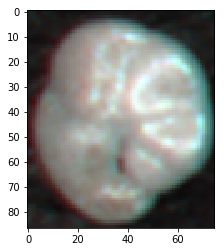

In [18]:
plt.imshow(img)
plt.imshow(img_2)
plt.show()

In [138]:
result = service.run(input_data=json.dumps({"data": forams}))

WebserviceException: Received bad response from service:
Response Code: 504
Headers: {'Date': 'Wed, 20 Mar 2019 20:40:47 GMT', 'Content-Type': 'text/plain; charset=utf-8', 'X-Ms-Request-Id': '80c5c219-14f7-4a2e-86cd-9d05548eb968', 'Content-Length': '109'}
Content: b'Post http://localhost:5001/score: net/http: request canceled (Client.Timeout exceeded while awaiting headers)'

In [7]:
forams = []
forams.append(img.tolist())
forams.append(img_2.tolist())
forams = json.dumps({"data": forams})
input_data = "{\"data\": [" + str(forams) + "]}"
headers = {'Content-Type':'application/json'}

# for AKS deployment you'd need to the service key in the header as well
# api_key = service.get_key()
# headers = {'Content-Type':'application/json',  'Authorization':('Bearer '+ api_key)} 
probs_error = json.dumps({"data": img.tolist()})
resp = requests.post('http://localhost:8000/score', forams, headers=headers)
resp = requests.post(service.scoring_uri, forams, headers=headers)

print("POST to url", service.scoring_uri)
print("prediction:", resp.text)

KeyboardInterrupt: 

In [9]:
# Test send to localhost
forams = []
forams.append(img.tolist())
# forams.append(img_2.tolist())
forams = json.dumps({"data": forams})
headers = {'Content-Type':'application/json'}
resp = requests.post('http://localhost:8000/score', forams, headers=headers)
print("prediction:", resp.text)

prediction: "{\"data\": {\"0\": {\"top_p\": [35.75677490234375, 18.668947219848633, 17.780595779418945, 4.468427658081055, 3.6045660972595215], \"top_classes\": [\"P. obliquiloculata\", \"G. ruber\", \"G. sacculifer\", \"G. elongatus\", \"G. hexagonus\"], \"true_class\": \"P. obliquiloculata\"}}}"


In [13]:
from azureml.core.model import Model
from azureml.core import Workspace
import numpy as np
import json
import torch
from torch import nn
from torchvision import models, transforms


def init():
    global model
    # retrieve the path to the model file using the model name
    ws = Workspace.get(name='foram-workspace', subscription_id='d90d34f0-1175-4d80-a89e-b74e16c0e31b')
    model_path = Model.get_model_path('foram-resnet18', _workspace=ws)
    model = load_checkpoint(model_path)


def run(raw_data):
    '''
    Must accept a json, must return a json
    '''
    try:
        to_return = {}
        data = list(json.loads(raw_data)['data'])
        for i, img in enumerate(data):
            img = np.array(img, dtype='uint8')
            top_p, top_classes, true_class = predict(model, img)
            to_return[i] = {'top_p':top_p.tolist(), 'top_classes': top_classes, 'true_class': true_class}
        to_return = json.dumps({'data': to_return})
        return to_return
    except Exception as e:
        result = str(e)
        # return error message back to the client
        return json.dumps({"error": result})


def process_image(image):
    """Process an image into a PyTorch tensor"""
    transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
    img = transform(image)
    return img


def predict(model, image, topk=5):
    """Make a prediction for an image using a trained model

    Params
    --------
        model (PyTorch model): trained model for inference
        topk (int): number of top predictions to return

    Returns
    top_p: the probabilites
    top_classes: top 5 classes
    """

    # Convert to pytorch tensor
    img_tensor = process_image(image)

    # Resize
    if torch.cuda.is_available():
        img_tensor = img_tensor.view(1, 3, 224, 224).cuda()
    else:
        img_tensor = img_tensor.view(1, 3, 224, 224)

    # Set to evaluation
    with torch.no_grad():
        model.eval()
        # Model outputs log probabilities
        out = model(img_tensor)
        ps = torch.exp(out)

        # Find the topk predictions
        topk, topclass = ps.topk(topk, dim=1)

        # Extract the actual classes and probabilities
        top_classes = [
            model.idx_to_class[class_] for class_ in topclass.cpu().numpy()[0]
        ]
        top_p = topk.cpu().numpy()[0]

        return top_p, top_classes, top_classes[0]


def load_checkpoint(path):
    model = models.resnet18(pretrained=True)
    model.fc = nn.Linear(model.fc.in_features, 17)
    model.load_state_dict(torch.load(path))
    model.idx_to_class = {num:species for num,species in enumerate(['G. crassaformis', 'G. elongatus', 'G. hexagonus', 'G. ruber', 'G. ruber pink', 'G. sacculifer', 'G. scitula', 'G. siphonifera', 'G. truncatulinoides', 'G. tumida', 'G. ungulata', 'N. acostaensis', 'N. dutertrei', 'N. humerosa', 'O. universa', 'P. obliquiloculata', 'S. dehiscen'])}
    return model


In [14]:
init()

In [15]:
forams = []
forams.append(img.tolist())
forams.append(img_2.tolist())
forams = json.dumps({"data": forams})
ans = run(forams)
print(ans)


{"data": {"0": {"true_class": "P. obliquiloculata", "top_p": [35.75677490234375, 18.668947219848633, 17.780595779418945, 4.468427658081055, 3.6045660972595215], "top_classes": ["P. obliquiloculata", "G. ruber", "G. sacculifer", "G. elongatus", "G. hexagonus"]}, "1": {"true_class": "G. scitula", "top_p": [394.2809143066406, 50.82872009277344, 6.9171013832092285, 4.208788871765137, 1.7130920886993408], "top_classes": ["G. scitula", "N. acostaensis", "S. dehiscen", "P. obliquiloculata", "G. sacculifer"]}}}


In [124]:
service.run(input_data=forams)

ConnectionError: HTTPConnectionPool(host='13.64.31.177', port=80): Max retries exceeded with url: /score (Caused by NewConnectionError('<urllib3.connection.HTTPConnection object at 0x7fdc72c618d0>: Failed to establish a new connection: [Errno 110] Connection timed out',))